# Demand Forecasting and Inventory Optimization: Feature Engineering and Model Training

**Objective:** This notebook outlines the critical steps of feature engineering for time series data and the training of a baseline demand forecasting model. We will transform raw date information into features that machine learning models can understand, split our data into training and testing sets, and then train and evaluate a chosen forecasting model.

**Author:** Muhammad Rizky Raihan

**Date:** 2025-05-26

## 1. Setup and Library Imports

We begin by importing all necessary Python libraries for data loading, manipulation, feature engineering, model training, and evaluation.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib # For saving the model

# Set plot style for better aesthetics
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

## 2. Data Loading

We will load the synthetic seasonal sales data generated in the previous notebook (`01_data_generation_eda.ipynb`).

In [2]:
# Load the synthetic sales data
try:
    df = pd.read_csv('../data/raw/synthetic_seasonal_sales.csv', index_col='Date', parse_dates=True)
    print("Data loaded successfully.")
    print(df.head())
except FileNotFoundError:
    print("Error: synthetic_seasonal_sales.csv not found. Please ensure it has been generated by running 01_data_generation_eda.ipynb.")
    exit() # Exit if data is not found

Data loaded successfully.
            Sales
Date             
2021-01-01     80
2021-01-02     70
2021-01-03     81
2021-01-04     94
2021-01-05     67


## 3. Feature Engineering

Feature engineering is the process of creating new input features from existing data to improve the performance of machine learning models. For time series data, this often involves extracting temporal information and creating lagged variables.

### 3.1. Temporal Features

Machine learning models, especially tree-based models like Random Forest, cannot directly understand the concept of time or seasonality from a `DatetimeIndex`. We need to extract numerical representations of time components.

We will extract the following features from the `Date` index:
* **Year**: Captures long-term trends.
* **Month**: Captures annual seasonality.
* **Day of Week**: Captures weekly seasonality (e.g., higher sales on weekends).
* **Day of Year**: Provides a continuous measure of progress through the year, capturing fine-grained annual seasonality more precisely than month.
* **Week of Year**: Similar to day of year, but on a weekly scale.
* **Quarter**: Captures quarterly business cycles.
* **Is Month Start/End**: Binary flags for the start/end of a month, which might impact sales due to payroll or promotional cycles.

**Why these features?**
These features provide the model with a structured way to learn time-dependent patterns. For instance, `Month` helps the model understand that sales generally peak in July, while `Day of Week` can identify typical Monday-Friday vs. weekend patterns. The `Day of Year` provides a more granular seasonal signal, distinguishing early July from late July.

In [4]:
# Create temporal features
df['year'] = df.index.year
df['month'] = df.index.month
df['day_of_week'] = df.index.dayofweek # Monday=0, Sunday=6
df['day_of_year'] = df.index.dayofyear
df['week_of_year'] = df.index.isocalendar().week.astype(int) # Using isocalendar for ISO week numbers
df['quarter'] = df.index.quarter
df['is_month_start'] = df.index.is_month_start.astype(int)
df['is_month_end'] = df.index.is_month_end.astype(int)

print("DataFrame with Temporal Features Head:")
df.head()

DataFrame with Temporal Features Head:


,Sales,year,month,day_of_week,day_of_year,week_of_year,quarter,is_month_start,is_month_end
Date,,,,,,,,,
2021-01-01,80,2021,1,4,1,53,1,1,0
2021-01-02,70,2021,1,5,2,53,1,0,0
2021-01-03,81,2021,1,6,3,53,1,0,0
2021-01-04,94,2021,1,0,4,1,1,0,0
2021-01-05,67,2021,1,1,5,1,1,0,0


### 3.2. Lagged Features

Lagged features are historical values of the target variable ($Y_t$) from previous time steps. They are highly effective in time series forecasting because past values are often strong predictors of future values.

A lagged feature at lag $k$ is simply the value of the target variable $Y_{t-k}$.

#### Mathematical Principle: Autocorrelation

The effectiveness of lagged features stems from the principle of **autocorrelation**, which measures the correlation between a time series and a lagged version of itself. A high autocorrelation at a specific lag indicates that past values at that lag are strongly related to current values.

Mathematically, the autocorrelation function (ACF) at lag $k$ is defined as:

$$
\rho_k = \frac{\text{Cov}(Y_t, Y_{t-k})}{\sqrt{\text{Var}(Y_t)\text{Var}(Y_{t-k})}}
$$

Where:
* $\text{Cov}(Y_t, Y_{t-k})$ is the covariance between the series at time $t$ and at time $t-k$.
* $\text{Var}(Y_t)$ and $\text{Var}(Y_{t-k})$ are the variances of the series at time $t$ and $t-k$, respectively.

We will create a few key lagged features:
* **Sales_Lag_1**: Sales from the previous day ($Y_{t-1}$). This is a strong immediate predictor.
* **Sales_Lag_7**: Sales from one week ago ($Y_{t-7}$). Useful for capturing weekly patterns.
* **Sales_Lag_365**: Sales from one year ago ($Y_{t-365}$). Crucial for capturing annual seasonality.

**Considerations for Lagged Features:**
* **Missing Values (NaNs):** Creating lagged features will introduce `NaN` values at the beginning of the series. For example, `Sales_Lag_1` will have a `NaN` on the first day. These must be handled, typically by dropping rows with `NaN`s for model training (verification: this simplifies the data preparation for this baseline model; in advanced scenarios, imputation techniques like forward fill or mean imputation could be considered if data loss is a major concern).
* **Data Leakage:** Ensure that lagged features only use past data relative to the prediction point. We are doing this correctly by simply shifting the series.

In [6]:
# Create lagged features
df['Sales_Lag_1'] = df['Sales'].shift(1)
df['Sales_Lag_7'] = df['Sales'].shift(7)
df['Sales_Lag_365'] = df['Sales'].shift(365)

# Drop rows with NaN values resulting from lagging
df.dropna(inplace=True)

print("\nDataFrame after creating lagged features and dropping NaNs:")
print("\nNumber of rows after dropping NaNs:", len(df))
df.head()


DataFrame after creating lagged features and dropping NaNs:

Number of rows after dropping NaNs: 731


,Sales,year,month,day_of_week,day_of_year,week_of_year,quarter,is_month_start,is_month_end,Sales_Lag_1,Sales_Lag_7,Sales_Lag_365
Date,,,,,,,,,,,,
2023-01-01,112,2023,1,6,1,52,1,1,0,98.0,125.0,85.0
2023-01-02,94,2023,1,0,2,1,1,0,0,112.0,116.0,94.0
2023-01-03,114,2023,1,1,3,1,1,0,0,94.0,110.0,90.0
2023-01-04,82,2023,1,2,4,1,1,0,0,114.0,112.0,90.0
2023-01-05,122,2023,1,3,5,1,1,0,0,82.0,117.0,77.0


## 4. Data Splitting (Train-Test Split)

For time series forecasting, it is paramount to perform a **time-based split** rather than a random split. This means using earlier data for training and later data for testing. Random splitting would introduce data leakage, as the model would "see" future information.

We will split our data into:
* **Training Set:** Data from the beginning up to a specific date (e.g., end of 2023).
* **Testing Set:** Data from that specific date onwards (e.g., entire year of 2024).

**Rationale for Time-Based Split:**
This mimics a real-world scenario where a model trained on historical data is used to predict future, unseen data. It provides an honest evaluation of the model's generalization capabilities.

Training set shape: (365, 11) (X) | (365,) (y)
Testing set shape: (366, 11) (X) | (366,) (y)


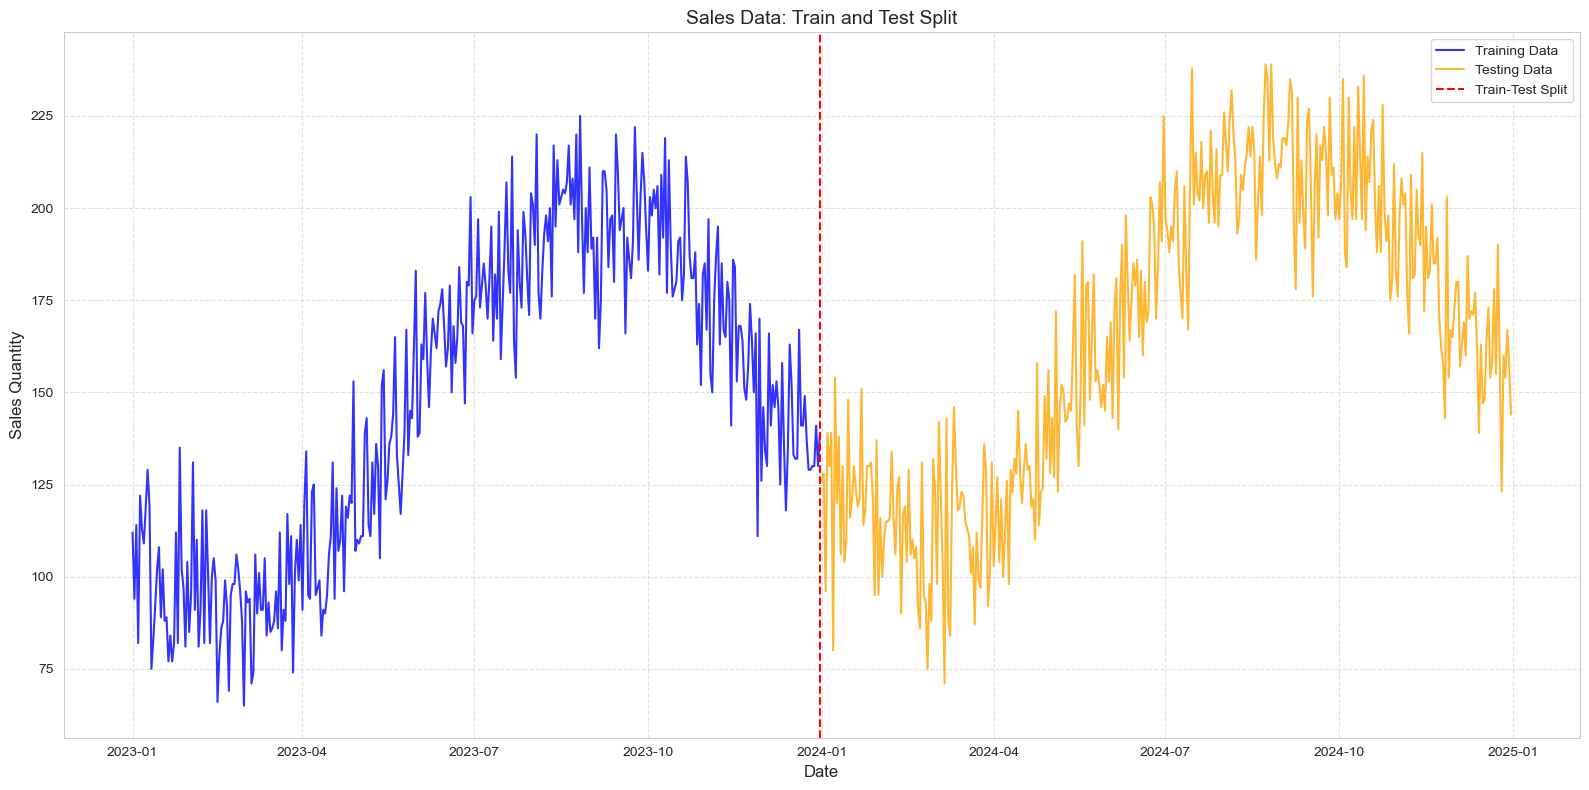

In [8]:
split_date = '2023-12-31'

train_df = df.loc[df.index <= split_date]
test_df = df.loc[df.index > split_date]

# Define features (X) and target (y)
features = ['year', 'month', 'day_of_week', 'day_of_year', 'week_of_year', 'quarter',
            'is_month_start', 'is_month_end', 'Sales_Lag_1', 'Sales_Lag_7', 'Sales_Lag_365']
target = 'Sales'

X_train, y_train = train_df[features], train_df[target]
X_test, y_test = test_df[features], test_df[target]

print(f"Training set shape: {X_train.shape} (X) | {y_train.shape} (y)")
print(f"Testing set shape: {X_test.shape} (X) | {y_test.shape} (y)")

# Visualize the split
plt.figure(figsize=(16, 8))
plt.plot(train_df.index, train_df['Sales'], label='Training Data', color='blue', alpha=0.8)
plt.plot(test_df.index, test_df['Sales'], label='Testing Data', color='orange', alpha=0.8)
plt.axvline(pd.to_datetime(split_date), color='red', linestyle='--', label='Train-Test Split')
plt.title('Sales Data: Train and Test Split')
plt.xlabel('Date')
plt.ylabel('Sales Quantity')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

## 5. Model Training: Random Forest Regressor 

To build a solid **baseline forecasting model**, we'll start with the **Random Forest Regressor**—a flexible, non-parametric ensemble method that's surprisingly effective even for time series tasks (when properly engineered).

---

### What is a Random Forest?

At its core, a **Random Forest** is an ensemble of decision trees. Rather than relying on a single model, it aggregates the predictions of many trees—each trained on a slightly different view of the data.

Formally, the prediction $\hat{y}$ from a Random Forest for regression is given by:

$$
\hat{y} = \frac{1}{T} \sum_{t=1}^T h_t(x)
$$

Where:

* $T$ is the total number of trees,
* $h_t(x)$ is the prediction from the $t^\text{th}$ tree for input $x$,
* $\hat{y}$ is the final prediction (mean of all tree outputs).

---

### How It Works

Random Forest builds on several key ideas:

1. **Ensemble Learning**
   Combines many "weak learners" (shallow decision trees) into a single "strong learner". Individually, a tree might be noisy or overfit—but together, their collective vote is surprisingly robust.

2. **Bagging (Bootstrap Aggregating)**
   Each tree is trained on a random subset of the training data **with replacement**. This reduces variance and helps prevent overfitting. Mathematically, this approximates sampling from the empirical distribution of the data.

3. **Feature Subsampling**
   At each split, a random subset of features is considered instead of all features. This introduces *decorrelation* between trees—so the errors from different trees are more likely to cancel each other out.

---

### Why Use It for Time Series Forecasting?

Although Random Forest isn't a traditional time series model (like ARIMA or Prophet), it works surprisingly well with **engineered temporal features** (e.g., day of week, month, lagged values, rolling means).

Here’s why it's a good choice:

✅ **Captures Nonlinear Relationships**
No need to assume linearity. The model learns complex patterns, such as nonlinear interactions between seasonality and trends.

✅ **Robust to Outliers**
Because decision trees split based on thresholds (not distance metrics), Random Forest is less sensitive to extreme values.

✅ **Built-in Feature Importance**
We can inspect which temporal or lag-based features the model relies on most.

✅ **Implicit Seasonality Handling**
Given features like `dayofyear`, `month`, or lagged variables, Random Forest can implicitly learn seasonal behavior—without requiring Fourier terms or decomposition.

---

### Hyperparameters (and Their Intuition)

For our **baseline model**, we'll use standard, proven defaults. These won't be optimal, but they give us a reasonable starting point:

| Parameter          | Value      | Why it matters                                                   |
| ------------------ | ---------- | ---------------------------------------------------------------- |
| `n_estimators=100` | 100 trees  | More trees reduce variance; after \~100, performance stabilizes. |
| `random_state=42`  | Fixed seed | Ensures results are reproducible.                                |

In real projects, you'd want to perform **hyperparameter tuning** (e.g., via `GridSearchCV`) to explore options like tree depth, minimum samples per split, or max features.

---

### Reference

> Breiman, L. (2001). Random Forests. *Machine Learning*, 45(1), 5–32.
> [DOI: 10.1023/A:1010933404324](https://doi.org/10.1023/A:1010933404324)

---


In [9]:
# Initialize and train the Random Forest Regressor model
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1) # n_jobs=-1 uses all available cores
print("Training Random Forest Regressor...")
model.fit(X_train, y_train)
print("Model training complete.")

Training Random Forest Regressor...
Model training complete.


## 6. Model Evaluation

After training, we evaluate the model's performance on the unseen test set. We will use several common regression metrics:

* **Mean Absolute Error (MAE):** The average of the absolute differences between predictions and actual values. It's robust to outliers.
    $$
    \text{MAE} = \frac{1}{N} \sum_{i=1}^{N} |y_i - \hat{y}_i|
    $$
* **Mean Squared Error (MSE):** The average of the squared differences between predictions and actual values. It penalizes larger errors more heavily.
    $$
    \text{MSE} = \frac{1}{N} \sum_{i=1}^{N} (y_i - \hat{y}_i)^2
    $$
* **Root Mean Squared Error (RMSE):** The square root of MSE. It's in the same units as the target variable, making it easier to interpret.
    $$
    \text{RMSE} = \sqrt{\frac{1}{N} \sum_{i=1}^{N} (y_i - \hat{y}_i)^2}
    $$
* **R-squared ($R^2$):** Represents the proportion of the variance in the dependent variable that is predictable from the independent variables. A value of 1 indicates perfect prediction.
    $$
    R^2 = 1 - \frac{\sum_{i=1}^{N} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{N} (y_i - \bar{y})^2}
    $$
    Where $y_i$ are actual values, $\hat{y}_i$ are predicted values, and $\bar{y}$ is the mean of actual values.

**Interpretation:**
* Lower MAE, MSE, and RMSE indicate better model accuracy.
* Higher $R^2$ indicates a better fit of the model to the data.

We will also visualize the predictions against the actual values to gain qualitative insights into the model's performance, especially how well it captures seasonality and trends in the test set.

Mean Absolute Error (MAE): 17.07
Mean Squared Error (MSE): 433.89
Root Mean Squared Error (RMSE): 20.83
R-squared (R2): 0.74


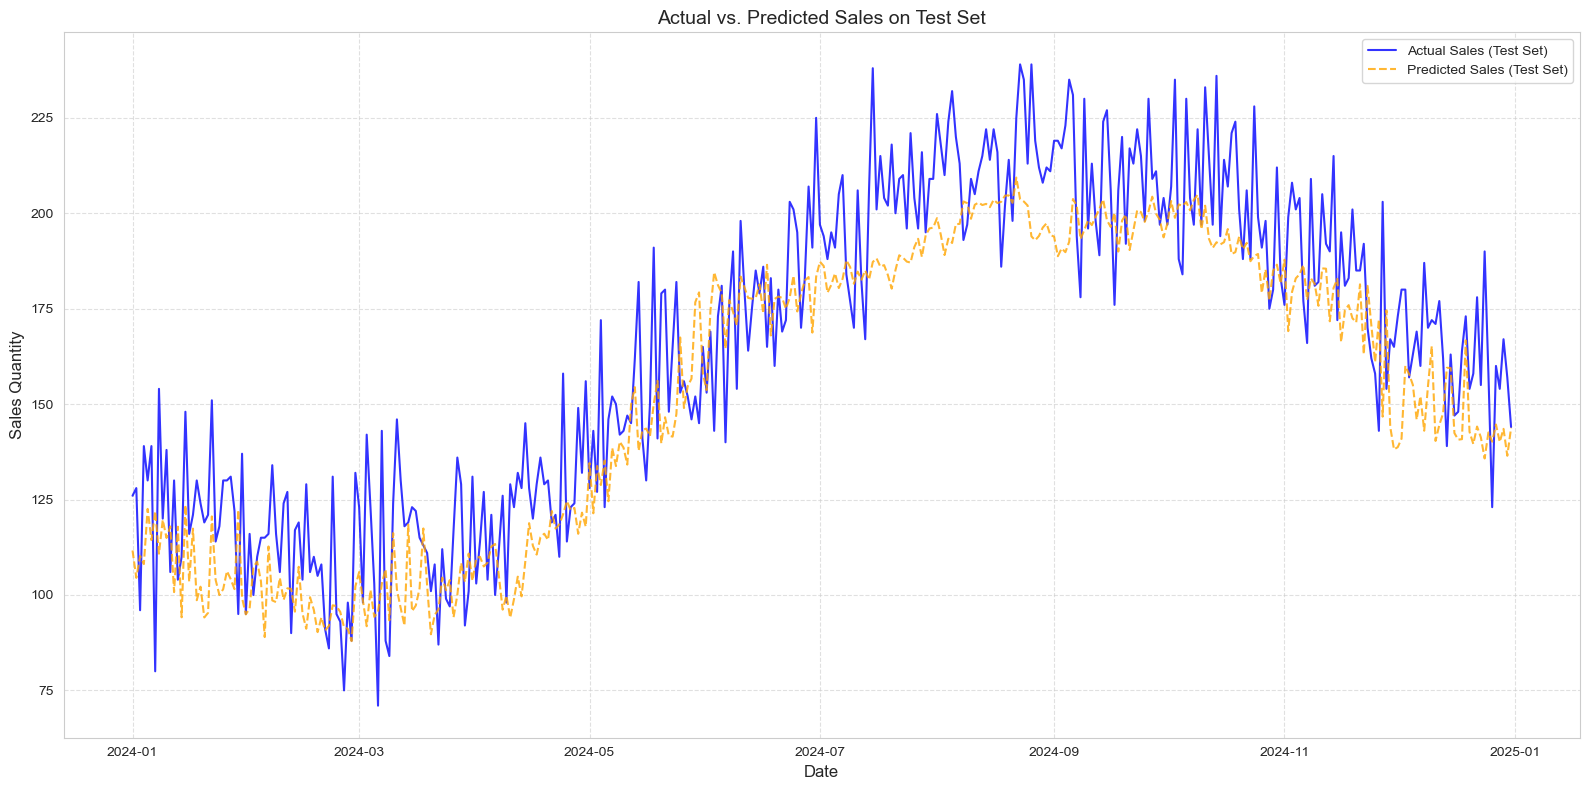

In [10]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R2): {r2:.2f}")

# Plot actual vs. predicted sales on the test set
plt.figure(figsize=(16, 8))
plt.plot(y_test.index, y_test, label='Actual Sales (Test Set)', color='blue', alpha=0.8)
plt.plot(y_test.index, y_pred, label='Predicted Sales (Test Set)', color='orange', linestyle='--', alpha=0.8)
plt.title('Actual vs. Predicted Sales on Test Set')
plt.xlabel('Date')
plt.ylabel('Sales Quantity')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### 6.1. Feature Importance

Random Forest models provide a measure of feature importance, indicating how much each feature contributes to the model's predictive power. This can offer valuable insights into which factors are most influential in determining sales.

**Mathematical Principle (Gini Importance):**
Feature importance in Random Forests is typically calculated based on the **Gini importance** (also known as Mean Decrease in Impurity). For each tree in the forest, the impurity decrease from splitting on a feature is calculated, averaged across all trees, and normalized. Features that result in larger impurity decreases are considered more important.

While useful, it's important to note that Gini importance can be biased towards features with more categories or continuous features. Other methods like permutation importance might offer a more robust view.

C:\Users\Raihan\AppData\Local\Temp\ipykernel_21468\3343232849.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=features_df, palette='viridis')


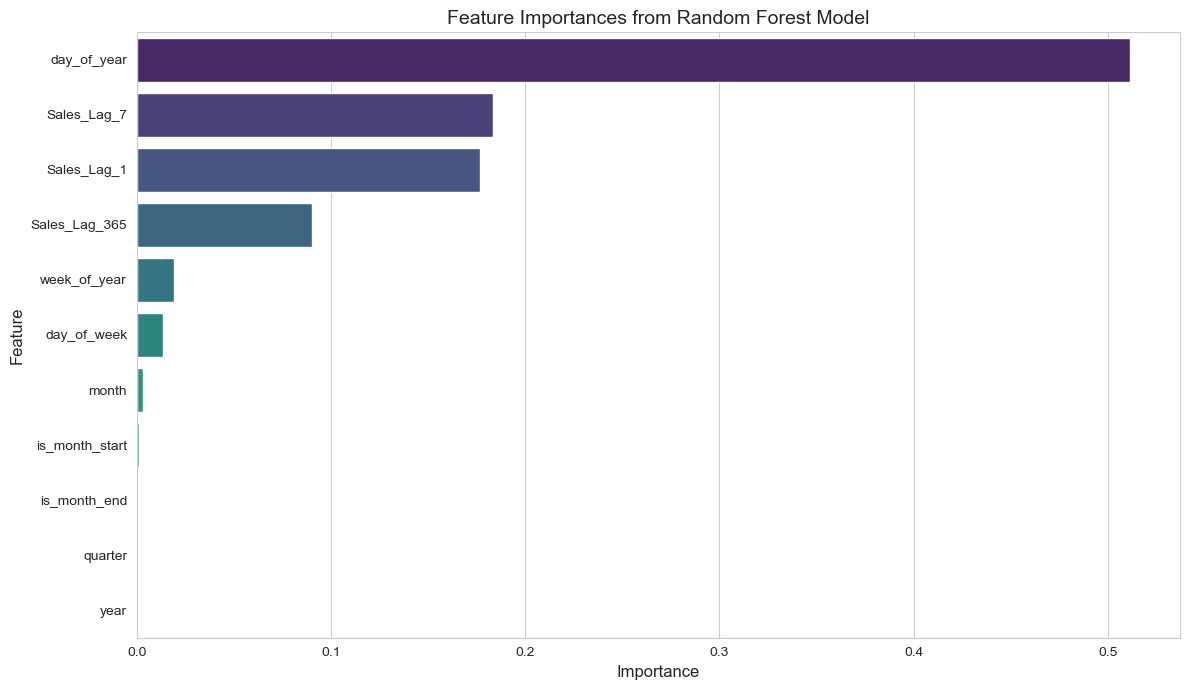


Top 5 Most Important Features:
          Feature  Importance
3     day_of_year    0.511574
9     Sales_Lag_7    0.183371
8     Sales_Lag_1    0.176815
10  Sales_Lag_365    0.089966
4    week_of_year    0.019132


In [11]:
# Get feature importances
feature_importances = model.feature_importances_
features_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
features_df = features_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 7))
sns.barplot(x='Importance', y='Feature', data=features_df, palette='viridis')
plt.title('Feature Importances from Random Forest Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

print("\nTop 5 Most Important Features:")
print(features_df.head())

## 7. Model Saving

To reuse our trained model for future predictions or within our Streamlit application, we will save it to disk. We use `joblib` for this purpose, as it's efficient for large NumPy arrays and objects.

In [12]:
# Save the trained model
model_path = '../models/random_forest_forecasting_model.pkl'
joblib.dump(model, model_path)
print(f"Trained model saved to: {model_path}")

Trained model saved to: ../models/random_forest_forecasting_model.pkl


## 8. Next Steps

With our baseline Random Forest model trained and evaluated, the next phase will involve:

1.  **Refinement and Comparison:** Potentially exploring more advanced forecasting models (e.g., Prophet, ARIMA, or even deep learning models like LSTMs) and comparing their performance.
2.  **Inventory Optimization Logic:** Integrating the demand forecasts into an inventory optimization framework to determine optimal stock levels and reorder points.
3.  **Streamlit Application Development:** Building the interactive user interface to showcase our demand forecasting and inventory optimization capabilities.

---

## 9. References

> Breiman, L. (2001). Random Forests. *Machine Learning*, 45(1), 5–32.
> [DOI: 10.1023/A:1010933404324](https://doi.org/10.1023/A:1010933404324)